In [ ]:
#hide
from IPython.display import HTML
import matplotlib.pyplot as plt
import proplot as plot
plot.rc['figure.facecolor'] = 'white'
plot.rc['axes.grid'] = False
plot.rc['lines.markeredgewidth'] = 0
plot.rc['image.cmap'] = 'PiYG'

# Authorship identification
- toc: true 
- badges: false
- comments: true
- categories: [stylometry, machine learning, natural language processing]

In 2020 I was able to take a few courses in the grad computer science department at UT Knoxville; the first was Data Mining and the second was Intro to Machine Learning. I thought should write about a few of the things I learned. One application of machine learning which I focused on is the task of *authorship identification*, that is, to identify the author of an unlabeled document given a list of possible authors and some sample of each author's writing. To learn about this topic, I attempted to reproduce the results of a paper titled *N-Gram Feature Selection for Authorship Identification* which can be found [here](https://www.researchgate.net/publication/221655968_N-Gram_Feature_Selection_for_Authorship_Identification). In this post I'll first motivate the problem of authorship identification, then briefly introduce the relevant statistical methods, and finally summarize and implement the methods in the paper.

<!-- <img src=images_next/task.png width=600> -->
![](images_next/task.png)

## Stylometry

### Motivation: the Federalist Papers

The Federalist Papers are an important collection of 85 essays written by Hamilton, Madison, and Jay during 1787 and 1788. The essays were published under the alias "Plubious", and although it became well-known that the three men were involved, the authorship of each individual paper was kept hidden for over a decade. This was actually in the interest of both Hamilton and Madison; both were politicians who had changed positions on a number of issues and didn't want their political opponents to use their own words against them. Days before his death, Hamilton allegedly wrote down who he believed to be the correct author of each essay, claiming over 60 for himself. Madison waited a number of years before publishing his own list, and in the end there were 12 essays claimed by both Madison and Hamilton. Many interesting details on the controversy can be found in a paper by [Adair](https://www.jstor.org/stable/1921883?read-now=1&seq=23#page_scan_tab_contents).

<img src=images_next/Hamilton_and_Madison.png width=550>
<figcaption>Alexander Hamilton (left) and James Madison (right). Credit: Wikipedia.</figcaption>

There are a few ways one might go about resolving this dispute. One approach is to analyze the actual *content* of the text. For example, perhaps an essay draws from a reference which only Madison was intimately familiar with, or perhaps an essay is similar to some previous work by Hamilton. This was done many times over the next 150 years, but perhaps the final word on the subject was by Adair, who in 1944 concluded that Madison likely wrote all 12 essays. An alternative approach is to analyze the *style* of the text. For example, maybe Madison used many more commas than Hamilton. The field of *stylometry* attempts to statistically quantify these stylistic differences. David Holmes writes the following about stylometry:
> *At its heart lies an assumption that authors have an unconscious aspect to their style, an aspect which cannot consciously be manipulated but which possesses features which are quantifiable and which may be distinctive.* 

I think this a valid assumption. The question is which features best characterize the author's style and which methods are best to use in the analysis of these features. Let's go back in time a bit to see how stylometry has developed over the past 150 years.

### History

The physicist [Thomas Mendenhall](https://en.wikipedia.org/wiki/Thomas_Corwin_Mendenhall) is considered the first to statistically analyze large literary texts. He presented the following interesting idea in an 1887 paper titled [*The Characteristic Curves of Composition*](https://www.jstor.org/stable/pdf/1764604.pdf): it is known that each chemical element emits light with a unique distribution of wavelengths when it is heated; perhaps each author has a unique distribution of word lengths in the texts they have written. It's a really cool idea, and I highly recommend reading his original paper. Mendenhall tallied word lengths by hand for various books, usually in batches of 1000 words or so. Here is Fig. 2 from his paper which shows the characteristic curves for a few excerpts of *Oliver Twist*.

<img src=images_next/Mendenhall_Fig2.png width=400>
<figcaption>Distribution of word lengths in "Oliver Twist". Each curve is for a different sample of 1000 words.</figcaption>

He showed that these curves are very interesting and that they do reveal similarities between different works by the same author. The use of these statistics for authorship identification was left for future work. 

The next significant advance in the statistical analysis of text was made by Zipf in 1932. Zipf found an interesting relationship between an integer $k$ and the frequency $f(k)$ of the $k$th most frequent word. This is often called a *rank-frequency* relationship where $k$ is the rank. The scaling law can be written as

$$ f(k) \propto k^{-1}. \tag{1} $$

The idea expressed by this law is that short words are much more frequent than large words. Surprisingly, the law holds up very well, albeit not perfectly, for most texts. *Why* this is the case is still unknown; a comprehensive review of the current state of the law can be found [here](https://link.springer.com/article/10.3758/s13423-014-0585-6). The law also shows up in other situations such as national GDP:

<img src=images_next/Cristelli_Fig1_big.png width=500>
<figcaption>Zipf’s Law for National GDPs over time, which appear to be moving toward the prediction by Zipf's Law (red line). From Ref. [1].</figcaption>

Although not directly applicable to authorship identification, the success of Zipf's Law was very encouraging and led to a flurry of new mathematical models. Stylometry reached a landmark case in the 1960's when researchers used the frequency distributions of short function words — words we don't think about too much like "upon" or "therefore" — to support Adair's conclusion that Madison wrote the 12 disputed Federalist Papers. 

At the end of the day, however, models created in the spirit of Zipf's Law are probably doomed to fail. The "true" underlying model must be very complex due to its dependence on human psychology. There are now many algorithms available which instead build predictive models directly from data, and these can be readily applied to the problem of authorship identification. Here we focus on the use of the Support Vector Machine (SVM).

## Support Vector Machine (SVM)

I include here the basic idea behind the SVM approach. There are a huge number of resources which go into the details [include the references]. I'll sort of follow the Wikipedia page since it has a nice short summary.

### Maximum margin hyperplane

Consider a binary linear classifier, i.e., a plane which splits the data into two classes. The equation for a plane in any number of dimensions is 

$$ y(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + w_0 = 0 \tag{2}. $$

This plane is called the *decision surface*; points are assigned to class 1 if $y(\mathbf{x}) > 0$ or class 2 when $y(\mathbf{x}) < 0$. Suppose the data is linearly separable (able to be completely split in two) and that we've found a plane which correctly splits the data. We could then scale the coordinates such that all points with $y(\mathbf{x}) \ge 1$ belong to class 1 and all points with $y(\mathbf{x}) \le -1$ belong to class 2. The separating plane then sits in the middle as in the following figure.

<br>
<img src=images_next/svm.png width=250>
<figcaption>Maximum margin separating plane. Credit: Wikipedia.</figcaption>

Notice that the plane could be rotated while still correctly splitting the existing data; the SVM attempts to find the optimal plane by maximizing the orthogonal distance from the decision plane to the closest point. This is known as the *margin*, and it can be shown that it is inversely proportional to the magnitude of $\mathbf{w}$. Thus, the SVM tries to minimize $|\mathbf{w}|^2$ subject to the constraint that all points are correctly categorized. New data is then assigned based on this optimal boundary.

Many datasets won't be linear separable. In this case there are two options for the SVM. The first is to add a penalty function in order to minimize the number of miscategorized points, so for *N* samples we minimize

$$ \frac{1}{2}|\mathbf{w}|^2 +  C\sum_{i=1}^{N}{\Theta\left[{t_i \, y(\mathbf{x}_i)}\right]} . \tag{3}$$

where $t_i$ is the true class of point $i$, $\Theta$ is the Heaviside step function, and $C$ is a positive constant. Let's try this on some toy data. The Python package [scikit-learn](https://scikit-learn.org/stable/modules/svm.html) has a user-friendly interface for the SVM implementation in [LIBLINEAR](https://www.csie.ntu.edu.tw/~cjlin/liblinear/) which we use here.

In [2]:
import numpy as np
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
import proplot as plot
import plotly.graph_objects as go
import seaborn as sns
from tqdm import tqdm, trange

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


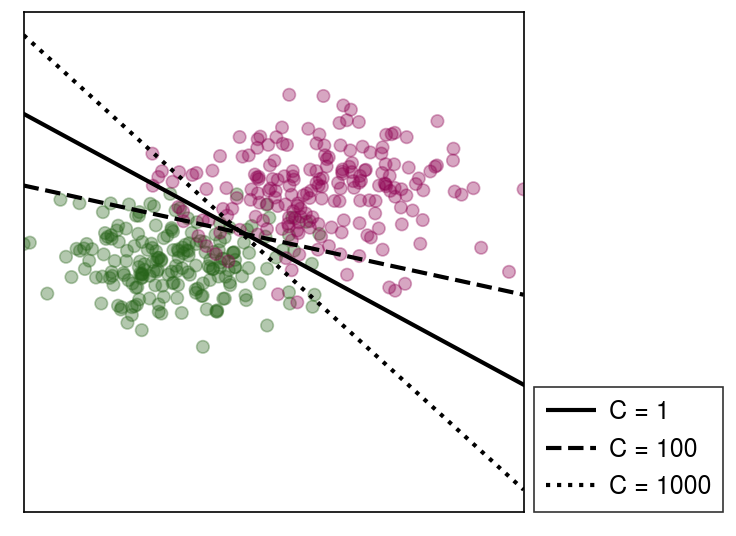

In [3]:

# Create two overlapping Gaussian distributions
np.random.seed(0)
n = 200
X = np.vstack([np.random.normal(size=(n, 2), loc=[0, 0], scale=2.0),
               np.random.normal(size=(n, 2), loc=[5, 5], scale=2.5)])
y = n * [1] + n * [-1] 

# Plot the data
fig, ax = plot.subplots()
ax.scatter(X[:, 0], X[:, 1], s=20, alpha=0.35, c=y)

# Plot decision boundary for different values of C
C_vals = [1, 100, 1000]
line_x = np.array([min(X[:, 0]), max(X[:, 0])])
for C, ls in zip(C_vals, ['solid', 'dashed', 'dotted']):
    clf = svm.LinearSVC(C=C)
    clf.fit(X, y)
    (w1, w2), w0 = clf.coef_[0], clf.intercept_
    line_y = -(w1 / w2) * line_x - (w0 / w2)
    ax.plot(line_x, line_y, c='k', ls=ls)
ax.legend(labels=['C = {}'.format(C) for C in C_vals], ncols=1, loc=(1.02, 0))
ax.format(xticks=[], yticks=[], xlim=line_x);

The three lines have significantly different angles, but all have around the same classification accuracy on the existing data. It can therefore be important to try at least a few different values of $C$, which determines the trade-off between correctly classifying all samples and maximizing the margin, and to observe the effect on the testing data classification accuracy. $C$ is known as a *hyperparameter* since it isn't changed by the algorithm during the training process, but is instead a property of the algorithm itself.

### Kernel trick

In some cases the linear model is going to be bad; a frequently used example is following "target" dataset.

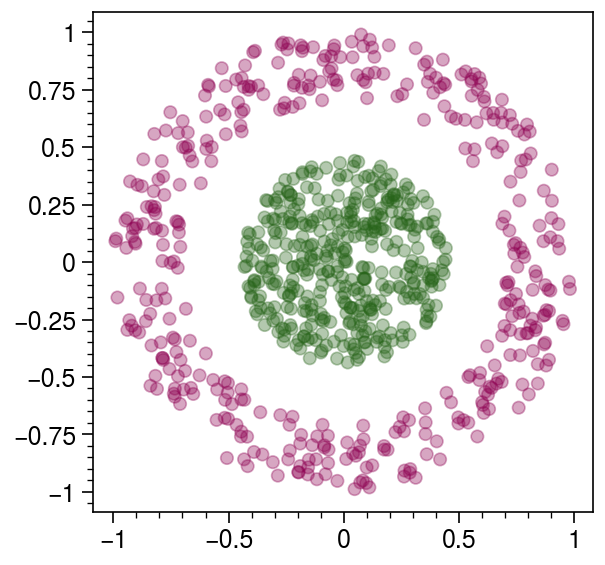

In [4]:
#collapse
n = 400
r1 = np.sqrt(np.random.uniform(0.0, 0.2, size=(n,)))
r2 = np.sqrt(np.random.uniform(0.5, 1.0, size=(n,)))
t1 = np.random.uniform(0, 2*np.pi, size=(n,))
t2 = np.random.uniform(0, 2*np.pi, size=(n,))
X = np.vstack([np.vstack([r1*np.cos(t1), r1*np.sin(t1)]).T,
               np.vstack([r2*np.cos(t2), r2*np.sin(t2)]).T])
y = n * [1] + n * [-1]

fig, ax = plot.subplots()
ax.scatter(X[:, 0], X[:, 1], s=20, alpha=0.35, c=y);

Obviously a line won't work; ideally we would draw a circle around the inner cluster to split the data. The so-called [kernel trick](https://en.wikipedia.org/wiki/Kernel_method) can be used to alleviate this problem by performing a transformation to a higher dimensional space in which the data is linearly separable. For example, consider the transformation

$$ (x_1, x_2) \rightarrow (x_1^2, x_2^2, \sqrt{2} x_1 x_2) . \tag{4}$$

In [5]:
#collapse
x1, x2 = X.T
u = x1**2
v = np.sqrt(2) * x1 * x2
w = x2**2
fig = go.Figure(data=go.Scatter3d(x=u, y=v, z=w, mode='markers', 
                                  marker=dict(color=y, size=5, opacity=0.5)))
HTML(fig.to_html(include_plotlyjs='cdn'))

It's clear from rotating the above plot that the data can be split with a 2D plane. This need not be the transformation used by the SVM — in fact, many transformations can be used — but it clearly demonstrates the idea. The linear boundary in the transformed space can then be transformed back to the original space in which it will be nonlinear. One way to plot this boundary is to make a prediction on a grid of points which covers the entire plot range.

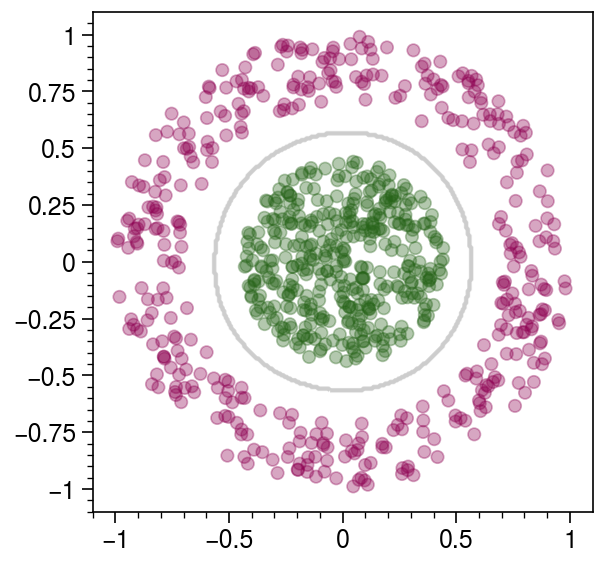

In [6]:
clf = svm.SVC(kernel='rbf')
clf.fit(X, y)

xx, yy = np.meshgrid(np.linspace(-1.1, 1.1, 300), np.linspace(-1.1, 1.1, 300))
Z = np.c_[xx.ravel(), yy.ravel()]
y_pred = clf.predict(Z)
zz = y_pred.reshape(xx.shape)

fig, ax = plot.subplots()
ax.scatter(X[:, 0], X[:, 1], s=20, alpha=0.35, c=y)
ax.contour(xx, yy, zz, alpha=0.05, cmap='binary');

Still, there are several advantages to the linear SVM. First, it is much faster to train, and second, the kernel trick may be unnecessary for high-dimensional data. As we'll see, text data can involve a large number of very high-dimensional samples. 

### Multi-class 

The two-class problem can be extended to multi-class problems. [Overview of method.] 

## N-grams and feature selection methods 

As I mentioned in the introduction, the paper I chose to follow to learn about this topic is called *N-Gram Feature Selection for Authorship Identification*. In short, the paper used *n-gram* frequencies (define shortly) as features in the classification task and developed a new method to select the most significant or "dominant" n-grams. This was tested on a collection of short news articles. Let's step through their method.

### Data set description 

The Reuters Corpus Volume 1 (RCV1) data set is a huge collection of news articles labeled by topic. Around 100,000 of these have known authors, and there are around 2000 different authors. A specific topic was chosen, and only authors who wrote at least one article which fell under this topic were considered. From this subset of authors, the top 50 in terms of number of articles written were chosen. 100 articles from each author were selected — 5000 in total — and these were evenly split into a training and testing set. The resulting corpus is a good challenge for authorship identification because 1) the genre is invariant across documents, and 2) the authors write about similar topics. Hopefully this leaves the author's style as the primary distinguishing factor. Another challenge is that the documents are quite short. The data set can be downloaded [here](https://archive.ics.uci.edu/ml/datasets/Reuter_50_50). The files are organized like this:

![](images_next/files.png)

There are plenty of functions available to load the data and to extract features from it, but I'll try to do everything manually since I'm not doing anything too complex. To load the data, let's first create two lists, `texts_train` and `texts_test`, corresponding to the 2500 training and testing documents. Each document is represented as a single string with spaces and new lines replaced with underscores. We also keep track of the correct author name and class id for each document.

In [7]:
from os import listdir
from os.path import join

def load_files(outer_path):
    texts, class_ids, class_names = [], [], []
    for class_id, folder in enumerate(sorted(listdir(outer_path))):
        folder_path = join(outer_path, folder)
        for filename in listdir(folder_path):
            class_ids.append(class_id)
            class_names.append(folder)
            file = open(join(folder_path, filename), 'r')
            text = file.read()
            for c in ('\n', ' '):
                text = text.replace(c, '_')
            texts.append(text)
            file.close()
    return texts, class_ids, class_names

texts_train, y_train, authors_train = load_files('reuters_data/train')
texts_test, y_test, authors_test = load_files('reuters_data/test')

In [164]:
#hide_input
df = pd.DataFrame()
df['Author Name'] = authors_train
df['Author ID'] = y_train
df['Training Text'] = texts_train
df

,Author Name,Author ID,Training Text
0,AaronPressman,0,A_group_of_leading_trademark_specialists_plans...
1,AaronPressman,0,Prospects_for_comprehensive_reform_of_U.S._ban...
2,AaronPressman,0,An_influential_economic_research_group_is_prep...
3,AaronPressman,0,The_Federal_Communications_Commission_proposed...
4,AaronPressman,0,An_international_task_force_charged_with_resol...
...,...,...,...
2495,WilliamKazer,49,China_could_list_more_railway_companies_and_is...
2496,WilliamKazer,49,The_choice_of_Singapore_for_the_listing_of_Chi...
2497,WilliamKazer,49,"China_ushered_in_1997,_a_year_it_has_hailed_as..."
2498,WilliamKazer,49,China_on_Tuesday_announced_a_ban_on_poultry_an...


### N-grams

An obvious feature candidate is word frequency; a less obvious one is *n-gram* frequency. A character n-gram is a string of length n. For example, the string *red_bike!* has the following 3-grams: *red*, *ed_*, *d_b*, *_bi*, *bik*, *ike*, *ke!*. These shorter strings may be useful because they capture different aspects of style such as the use of punctuation or certain prefixes/suffixes. In order to use these features in the SVM classifier, we need to create a feature matrix $X$ where $X_{ij}$ is the frequency of the jth n-gram in the ith document. Thus, each document is represented as a vector in $k$ dimensional space, where $k$ is the number of unique n-grams selected from the training documents.

We must first choose the value of n, which can be fixed or allowed to vary. I'll follow the authors and choose 3 $\le$ n $\le$ 5 since other studies have shown that these are generally the most effective. The vocabulary size is determined by the documents, but we could choose to keep only the most frequent n-grams. For example, we could choose the most frequent 2000 3-grams, 1000 4-grams, and 500 5-grams into a single vocabulary of size 3,500. After the vocabulary is built and each document is converted to a vector of n-gram counts, we'll scale each vector by it's norm so that all points are mapped to the surface of the $k$-dimensional unit sphere while preserving the angles between the vectors. I found this to slightly improve the SVM performance.

In [10]:
from collections import Counter

def get_ngrams(text, n):
    return [text[i - n : i] for i in range(n, len(text) + 1)]

def get_ngrams_in_range(text, min_n, max_n):
    ngrams = []
    for n in range(min_n, max_n + 1):
        ngrams.extend(get_ngrams(text, n))
    return ngrams

def sort_by_val(dictionary, max_items=None, reverse=True):
    n_items = len(dictionary)
    if max_items is None or max_items > n_items:
        max_items = n_items
    sorted_key_val_list = sorted(dictionary.items(), key=lambda item: item[1], 
                                 reverse=reverse)
    return {k: v for k, v in sorted_key_val_list[:max_items]}


class NgramExtractor:
    
    def __init__(self, ngram_range=(3, 5)):
        self.vocab = {}
        self.set_ngram_range(ngram_range)
        
    def set_ngram_range(self, ngram_range):
        self.min_n, self.max_n = ngram_range
        
    def build_vocab(self, texts, max_features=None):
        self.vocab, index = {}, 0
        for n in range(self.min_n, self.max_n + 1):
            ngrams = []
            for text in texts:
                ngrams.extend(get_ngrams(text, n))
            for ngram, count in sort_by_val(Counter(ngrams), max_features).items():
                self.vocab[ngram] = (index, count)
                index += 1
    
    def create_feature_matrix(self, texts, norm_rows=True):
        X = np.zeros((len(texts), len(self.vocab)))
        for i, text in enumerate(texts):
            doc_vocab = Counter(get_ngrams_in_range(text, self.min_n, self.max_n))
            for ngram, count in doc_vocab.items():
                if ngram in self.vocab:
                    j = self.vocab[ngram][0]
                    X[i, j] = count
        if norm_rows:
            X = np.apply_along_axis(lambda row: row / np.linalg.norm(row), 1, X)
        return X

As an example, we can use as features every 3-gram, 4-gram, and 5-gram in the training documents.

In [128]:
ngram_range = (3, 5)
max_features = None
norm_rows = True

extractor = NgramExtractor(ngram_range)
extractor.build_vocab(texts_train, max_features)
X_train = extractor.create_feature_matrix(texts_train, norm_rows)
X_test = extractor.create_feature_matrix(texts_test, norm_rows)

Here are some of the values in `X_train`. The columns have been sorted by descending frequency from left to right. 

In [131]:
#hide_input
df = pd.DataFrame(X_train, columns=extractor.vocab.keys())
df

,_th,he_,the,_in,ed_,_to,ng_,ing,to_,_of,...,"_""rus","""rust",_bast,basti,astio,ry)_e,y)_ea,d_Muc,"_""Soc","""Soci"
0,0.080437,0.080437,0.053625,0.080437,0.053625,0.026812,0.080437,0.080437,0.026812,0.053625,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.201583,0.192420,0.197001,0.064140,0.064140,0.032070,0.105373,0.096210,0.032070,0.050396,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.223512,0.179686,0.192834,0.078887,0.074504,0.074504,0.087652,0.083269,0.074504,0.070122,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.174039,0.174039,0.164370,0.072516,0.077351,0.072516,0.043510,0.048344,0.077351,0.077351,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.160459,0.171920,0.143267,0.045845,0.103152,0.080230,0.045845,0.045845,0.051576,0.057307,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.108572,0.144763,0.103402,0.067212,0.056871,0.093062,0.180954,0.118913,0.077552,0.118913,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2496,0.190798,0.139918,0.152638,0.105999,0.114479,0.059359,0.105999,0.165358,0.059359,0.139918,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2497,0.259207,0.206556,0.206556,0.068852,0.113403,0.085052,0.206556,0.113403,0.076952,0.113403,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2498,0.204479,0.209467,0.179543,0.089771,0.129670,0.079797,0.074809,0.054860,0.074809,0.114708,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


We can now feed this array to the SVM and make predictions on the testing data. I'll keep the $C$ parameter fixed at $C = 1$ in all cases since this is what is done in the paper (I tried a few different values of $C$ and there wasn't a large effect on the accuracy).

In [13]:
#hide_output
clf = svm.LinearSVC(C=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

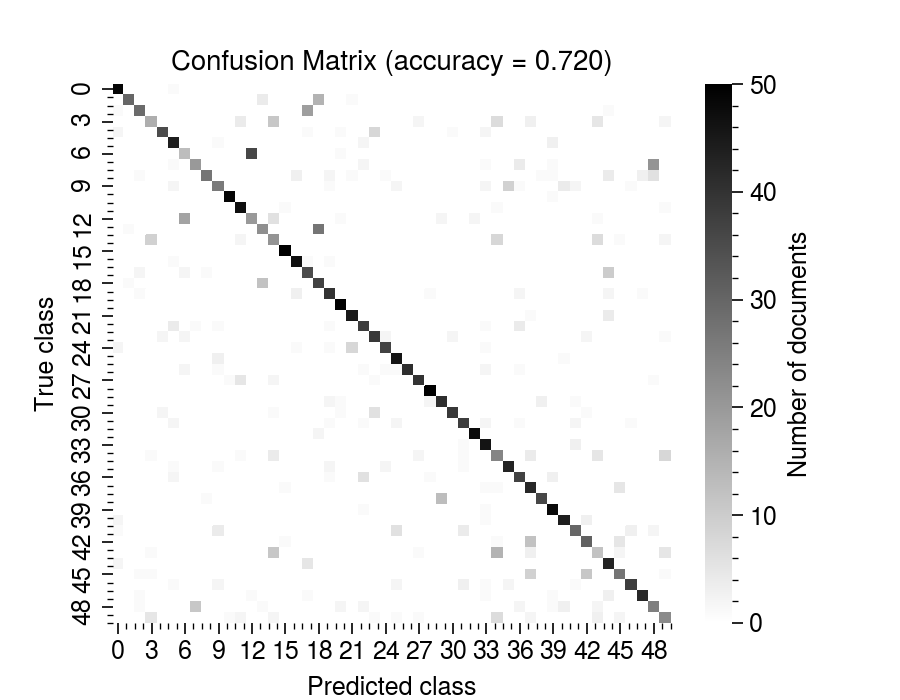

In [14]:
#collapse
from sklearn.metrics import accuracy_score, confusion_matrix

acc = accuracy_score(y_test, y_pred)
cmat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(4.5, 3.5))
sns.heatmap(cmat, ax=ax, cmap='binary', cbar_kws=dict(label='Number of documents'))
ax.set_title('Confusion Matrix (accuracy = {:.3f})'.format(acc))
ax.set_ylabel('True class'); ax.set_xlabel('Predicted class');

### Feature selection

In the above example, we used all 3-grams, 4-grams, and 5-grams in the training documents. The resulting accuracy is pretty good (keep in mind that random guessing will lead to 2% accuracy, not 50%). In the rest of this post, we'll study how the accuracy scales as the number of features is decreased. The motivation for doing so is two-fold. First, considering that our relatively small corpus produced 451,499 n-grams, the training time could become a limiting factor for larger data sets. Second, limiting the number of features reveals the qualities of n-grams which are most helpful for authorship identification. This process of selecting features which are "best" in some sense is known as *feature selection*.

#### Information gain

A classical statistical measure of feature "goodness" is called *information gain* (IG). The idea is that knowing whether or not a term *t* is found in a document of a known class $c$ gives information about $c$, and that some terms will contribute more information than others. The information gain can be written as

$$ IG(t) = -\sum_{i=1}^{m}p(c_i) \log p(c_i) + p(t) \sum_{i=1}^{m}p(c_i | t) \log p(c_i | t) +  p(\bar{t}) \sum_{i=1}^{m}p(c_i | \bar{t}) \log p(c_i | \bar{t}) . \tag{5}$$

The probability of choosing term $t$ out of all terms in the corpus is given by $p(t)$ , and $p(t) + p(\bar{t}) = 1$. Similarly, $p(c_i)$ is the probability that a randomly chosen document belongs to class $c_i$. The probability that a document belongs to $c_i$ is $p(c_i | t)$ if it contains $t$ or $p(c_i | \bar{t})$ if it doesn't contain $t$. The strategy is then to keep the terms with the highest information gain scores. [Say a bit more about the three terms in Eq. (5)]. The terminology can be a bit inconsistent from the papers I read; this is taken from [] and is the expected value of the pointwise mutual information. 

In [15]:
class InfoGainSelector:
    
    def __init__(self):
        self.idx = None
        
    def fit(self, X, y):
        # Compute probability distributions
        n_docs, n_terms = X.shape
        n_classes = len(np.unique(y))
        P_c_and_t = np.zeros((n_classes, n_terms))
        for doc_index, class_index in enumerate(y):
            P_c_and_t[class_index, :] += (X[doc_index, :] > 0).astype(int)
        P_c_and_t /= np.sum(P_c_and_t)
        P_t = np.sum(P_c_and_t, axis=0)
        P_c = np.sum(P_c_and_t, axis=1)
        P_c_given_t = P_c_and_t / P_t
        P_c_given_tbar = 1 - (1 - P_c_and_t) / (1 - P_t)
        
        # Compute information gain for each feature
        def XlogX(X):
            return X * np.log2(X, out=np.zeros_like(X), where=(X > 0))
        scores = np.zeros(n_terms)
        scores += np.sum(P_t * XlogX(P_c_given_t), axis=0)
        scores += np.sum((1 - P_t) * XlogX(P_c_given_tbar), axis=0)
        scores -= np.sum(XlogX(P_c))
        self.idx = np.argsort(scores)
        return scores
        
    def select(self, X, k=-1):  
        return X[:, self.idx[:k]]

To test this method, we'll compare 4 sets of 15,000 features: 3-grams, 4-grams, 5-grams, and equal parts 3/4/5-grams.

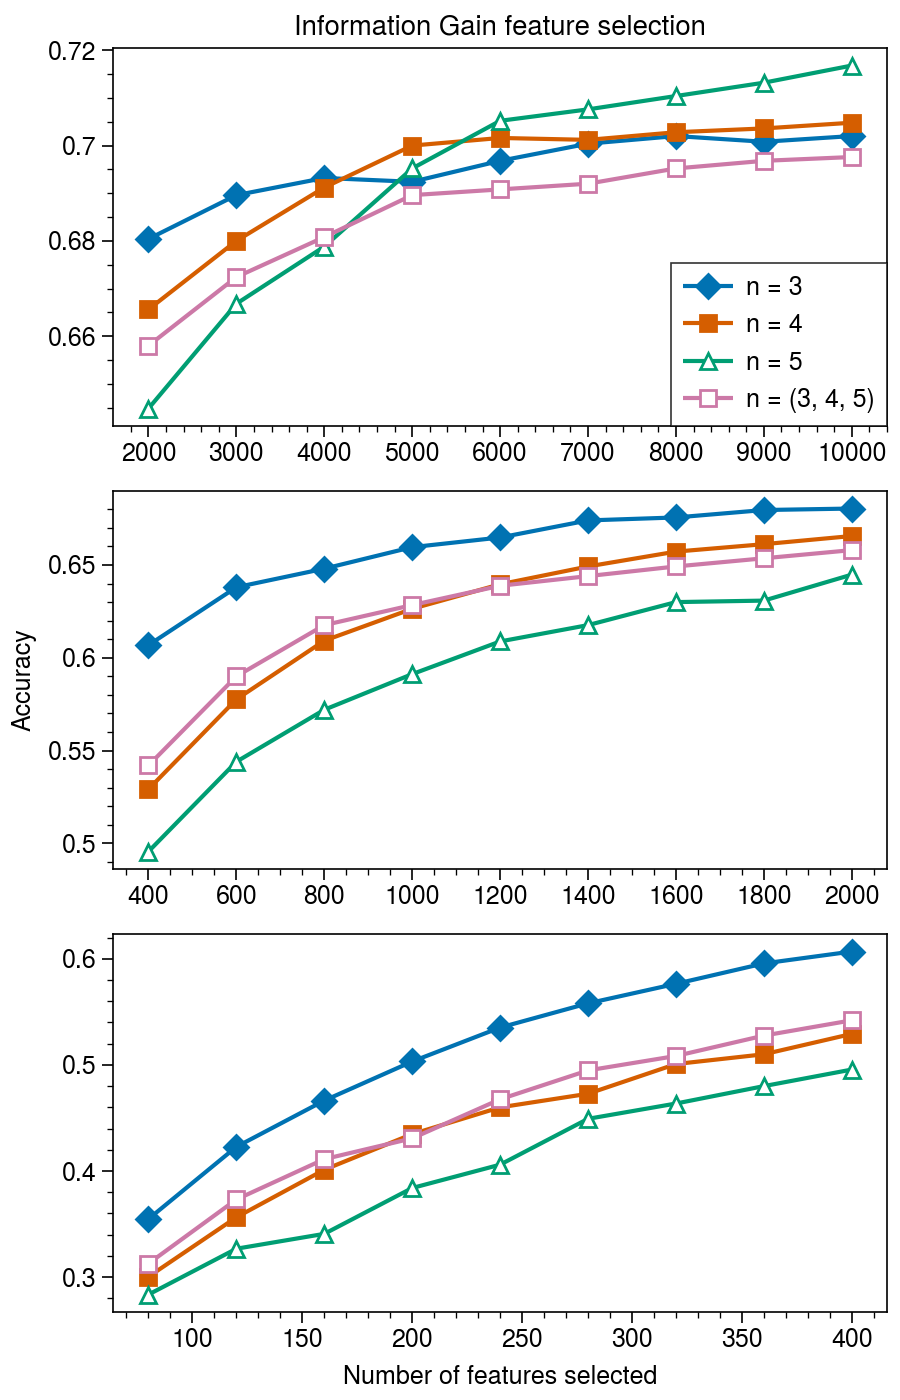

In [134]:
#collapse
extractor = NgramExtractor()
selector = InfoGainSelector()
clf = svm.LinearSVC(C=1)
ngram_ranges = [(3, 3), (4, 4), (5, 5), (3, 5)]

def acc_vs_nfeat_ig(kmin, kmax, kstep):
    n_keep = np.arange(kmin, kmax + kstep, kstep).astype(int)
    accuracies = np.zeros((len(ngram_ranges), len(n_keep)))
    for i, ngram_range in enumerate(ngram_ranges):
        extractor.set_ngram_range(ngram_range)
        max_features = 5000 if ngram_range == (3, 5) else 15000
        extractor.build_vocab(texts_train, max_features)
        X_train = extractor.create_feature_matrix(texts_train)
        X_test = extractor.create_feature_matrix(texts_test)
        selector.fit(X_train, y_train)
        acc_list = []
        for j, k in enumerate(n_keep):
            X_train_red = selector.select(X_train, k)
            X_test_red = selector.select(X_test, k)
            clf.fit(X_train_red, y_train)
            y_pred = clf.predict(X_test_red)
            accuracies[i, j] = accuracy_score(y_test, y_pred)
    return accuracies

accuracies_list = []
kmins, kmaxs, kstep = (2000, 400, 80), (10000, 2000, 400), (1000, 200, 40)
for kmin, kmax, kstep in zip(kmins, kmaxs, ksteps):
    accuracies_list.append(acc_vs_nfeat_ig(kmin, kmax, kstep))
    
    
fig, axes = plot.subplots(nrows=3, figsize=(4.5, 7), sharex=False)
for i in range(len(ngram_ranges)):
    m = ['D', 's', '^', 's'][i]
    mfc = [None, None, 'w', 'w'][i]
    for j in range(len(kmins)):
        xvals = np.arange(kmins[j], kmaxs[j] + ksteps[j], ksteps[j])
        yvals = accuracies_list[j][i, :]
        axes[j].plot(xvals, yvals, marker=m, markeredgewidth=1, markerfacecolor=mfc)
axes[0].format(title='Information Gain feature selection')
axes[2].format(xlabel='Number of features selected')
axes.format(ylabel='Accuracy')
axes[0].legend(labels=['n = 3', 'n = 4', 'n = 5', 'n = (3, 4, 5)'], ncols=1);

Note that the horizontal scale is reduced by a factor of 5 in each plot starting from the top. It's clear that the performance decreases with feature number, so it seems best to keep as many features as possible for this data set and classifier (it's not obvious to me that this should be the case in general). But it's also clear that keeping more features has less and less effect on the accuracy as the number of features grows. Recall our first example in which all 3, 4, and 5-grams were used to give an accuracy of 0.72. Here we were able to discard the majority of features (451,449 $\rightarrow$ 10,000) at the cost of only 2-3% accuracy. Now, I should compare to the Fig. 1 from Stamatatos: 

![](images_next/stamatatos_fig1.png)

The markers are the same for easy comparison. To my disappointment, the peak accuracy is higher than I was able to achieve. Althought it's only a few percent, I think it points to some error in my implementation of IG given that Fig. 1 is from a peer reviewed journal and that my figure is produced by me. A further discrepency is the relative effectiveness of the different feature choices; I found 3-grams to be best for small feature numbers, while Stamatatos found them to be worst. The opposite is true of 5-grams. Again, the cause of this is unknown and I would trust the paper's conclusions over mine. Despite these differences, I think we've succeeded in demonstrating the effectiveness of the IG method.

#### LocalMaxs algorithm

One downside of IG is that it doesn't consider relationships between similar features. Consider the word bigram *Amelia Earhart*. These two words are very likely to be found next to each other and could probably be treated as a single multi-word unit. This leads to the idea of a "glue" which holds the words together; the glue between *Amelia* and *Earhart* is probably much stronger than the glue between *red* and *Earhart*. A technique has been developed to quantify this glue and extend the calculation to word n-grams instead of just word bi-grams. We're dealing instead with characters, but the idea is the same. 

Let $g(C)$ be the glue of character n-gram $C = c_1 \dots c_n$. Assuming we had to calculate the glue, how could this concept be used for feature selection? One solution is called the LocalMaxs algorithm. First define an antecedent $ant(C)$ as an (n-1)-gram which is contained in $C$, e.g., "string" $\rightarrow$ "strin" or "tring". Then define a successor $succ(C)$ as an (n+1)-gram which contains $C$, e.g., "string" $\rightarrow$ "strings" or "astring". *C* is selected as a feature if

$$ g(C) \ge g(ant(C)) \,\, and \,\, g(C) > g(succ(C)) \tag{6}$$

for all *ant*(C) and *succ*(C). Since we're dealing with 3 $\le$ n $\le$ 5, only the latter condition is checked if n = 3. Eq. (6) says that the glue of a selected feature shouldn't increase by adding a character to or removing a character from the start or end of the n-gram, i.e., the glue is at a local maximum with respect to similar n-grams. Now that the selection criteria are established, we can move on to calculating the glue. Here there are several options, but the one used in the paper is called *symmetrical conditional probability* (SCP). If we have a bigram $C = c_1c_2$, then

$$ SCP(c_1c_2) = p(c_1|c_2) \cdot p(c_2|c_1) = \frac{p(c_1,c_2)^2}{p(c_1)p(c_2)}, \tag{7}$$

so SCP is a measure of how likely one character is given the other. This formula can be applied to an n-gram $C = c_1\dots c_n$ by performing a *pseudo bigram transformation*, which means splitting the n-gram into two parts at a chosen *dispersion point*; for example, "help" could be split as "h\*elp", "he\*lp", or "hel\*p", where * is the dispersion point. Splitting $C$ as $c_1 \dots c_{n-1}$*$c_n$ would give

$$ SCP((c_1 \dots c_{n-1})c_n) = \frac{p(c_1 \dots c_n)^2}{p(c_1 \dots c_{n-1})p(c_n)}. \tag{8}$$

The problem here is that the answer will depend on where the dispersion point. We therefore introduce the FairSCP which averages over the possible dispersion points:

$$ FairSCP(c_1 \dots c_n) = \frac{p(c_1 \dots c_n)^2}{\frac{1}{n-1}\sum_{i=1}^{n-1} p(c_1 \dots c_i)p(c_{i+1} \dots c_n)}. \tag{9}$$

In summary, LocalMaxs loops through every n-gram in the vocabulary, computes the glue as $g(C) = FairSCP(C)$, and keeps the n-gram if Eq. (6) is satisfied. It differs from IG selection in that the features are not ranked, so the number of selected features is completely determined by the text. The method is implemented below.

In [124]:
import string

def antecedents(ngram):
    return [ngram[:-1], ngram[1:]]

def successors(ngram, characters=None):
    if characters is None:
        characters = string.printable
    successors = []
    for character in characters:
        successors.append(character + ngram)
        successors.append(ngram + character)
    return successors

In [125]:
class LocalMaxsExtractor(NgramExtractor):
    
    def __init__(self, ngram_range=(3, 5)):
        super().__init__(ngram_range)
        self.fixed_n_vocabs = [] # ith element holds global counts of (i+1)-grams
        
    def build_vocab(self, texts, max_features=None):
        # Extract all n-grams with 1 <= n <= self.max_n + 1
        self.fixed_n_vocabs, self.fixed_n_total_counts = [], []
        for n in range(1, self.max_n + 2):
            ngrams = []
            for text in texts:
                ngrams.extend(get_ngrams(text, n))
            fixed_n_vocab = Counter(ngrams)
            self.fixed_n_vocabs.append(fixed_n_vocab)
            self.fixed_n_total_counts.append(sum(fixed_n_vocab.values()))
        self.available_characters = self.fixed_n_vocabs[0].keys()
        # Select n-grams whose glue is at local maximum 
        self.vocab, index = {}, 0
        for n in range(self.min_n, self.max_n + 1):
            for ngram, count in sort_by_val(self.fixed_n_vocabs[n - 1], max_features).items():
                if self.is_local_max(ngram):
                    self.vocab[ngram] = (index, count)
                    index += 1
                    
    def is_local_max(self, ngram, return_better=False):
        glue = self.glue(ngram)    
        for succ in successors(ngram, self.available_characters):
            if self.glue(succ) >= glue:
                return False
        if len(ngram) > self.min_n:
            for ant in antecedents(ngram):
                if self.glue(ant) > glue:
                    return False 
        return True
                    
    def glue(self, ngram):
        n = len(ngram)
        P = self.fixed_n_vocabs[n - 1].get(ngram, 0) / self.fixed_n_total_counts[n - 1]
        if P == 0:
            return 0.0
        denom = 0.0
        for disp_point in range(1, n):
            ngram_l, ngram_r = ngram[:disp_point], ngram[disp_point:]
            n_l, n_r = disp_point, n - disp_point
            P_l = self.fixed_n_vocabs[n_l - 1].get(ngram_l, 0) / self.fixed_n_total_counts[n_l - 1]
            P_r = self.fixed_n_vocabs[n_r - 1].get(ngram_r, 0) / self.fixed_n_total_counts[n_r - 1]
            denom += P_l * P_r
        denom /= (n - 1)
        return P**2 / denom

We can do a quick check on a common word:

In [126]:
extractor = LocalMaxsExtractor()
extractor.set_ngram_range((3, 5))
extractor.build_vocab(texts_train, 2000)
print(len(extractor.vocab))

589


^ This is wrong. In the paper it is stated that an initial space of 6000 multi-length n-grams produces about 2300 local max n-grams. I would suggest just rewriting the class and seeing if the answer changes...

In [ ]:
# X_train_red = extractor.create_feature_matrix(texts_train)
# X_test_red = extractor.create_feature_matrix(texts_test)

# clf = svm.LinearSVC(C=1)
# clf.fit(X_train_red, y_train)
# y_pred = clf.predict(X_test_red)
# print(accuracy_score(y_test, y_pred))

In [ ]:
# extractor = LocalMaxsExtractor(ngram_range=(3, 5))
# extractor.build_vocab(texts_train, max_features=None)

# ngrams = ['that', 'that_', '_that', 'tha']
# for ngram in ngrams:
#     glue = extractor.glue(ngram)
#     is_local_max, better_ngram = extractor.is_local_max(ngram, return_better=True)
#     print(ngram)
#     print('    glue = {:.3f}'.format(glue))
#     if better_ngram != '':
#         print('    Found neighbor with higher glue: {}'.format(better_ngram))
#     else:
#         print('    Glue is locally maximum')

The successor *that_Q* has a higher glue than *that_*... interesting.

In [ ]:
# #collapse
# extractor = LocalMaxsExtractor()
# clf = svm.LinearSVC(C=1)

# ngram_ranges = [(3, 3), (4, 4), (5, 5), (3, 5)][-1:]
# max_features_list = np.arange(3000, 15000, 3000).astype(int)
# accuracies = np.zeros((len(ngram_ranges), len(max_features_list)))
# n_kept_features = np.zeros((len(ngram_ranges), len(max_features_list)))
# vocabs = []

# for i, ngram_range in enumerate(ngram_ranges):
#     print('ngram_range =', ngram_range)
#     extractor.set_ngram_range(ngram_range)
#     for j, max_features in enumerate(max_features_list):
#         _max_features = max_features // 3 if ngram_range == (3, 5) else max_features
#         extractor.build_vocab(texts_train, _max_features)
#         X_train_red = extractor.create_feature_matrix(texts_train)
#         X_test_red = extractor.create_feature_matrix(texts_test)
#         clf.fit(X_train_red, y_train)
#         y_pred = clf.predict(X_test_red)
#         accuracies[i, j] = accuracy_score(y_test, y_pred)
#         n_kept_features[i, j] = len(extractor.vocab)
#         vocabs.append(extractor.vocab)
        
# fig, ax = plot.subplots(figsize=(4.5, 2.5))
# for i in range(len(ngram_ranges)):
#     ax.plot(n_kept_features[i], accuracies[i], marker='o', ms=5)
# ax.format(ylabel='Accuracy', xlabel='Number of features selected', title='LocalMaxs feature selection')
# ax.legend(labels=['n = 3', 'n = 4', 'n = 5', 'n = (3, 4, 5)'], ncols=1);

## Conclusion

This post essentially summarized a research paper in the field of Natural Language Processing. I think such a summary e is a good way to learn about a new topic — first there is some background theory to understand (SVM), then perhaps a specific algorithm to implement (LocalMAXS). In the future, I'd like to write some posts in which I create and analyze a data set in my own way. One idea I had was to examine the problem of *artist* identification; it would be interesting to see if I could match a collection of paintings with their correct painters. The [Web Gallery of Art](https://www.wga.hu/index.html) is one database I found after a quick search, and I'm sure there are others. This is related to the problem of authorship identification in that one would need to find statistically significant stylistic differences between painters, but the features will be completely different. 